In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.geodesic import Geodesic
land_color = [85/255, 92/255, 105/255]
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=land_color)
plt.rcParams['axes.grid'] = True
import numpy as np
import xarray as xr
import pandas as pd
import gsw, os
etopo = xr.open_dataset('/home1/datawork/kbalem/ETOPO1_Bed_g_gmt4.nc')
gebco = xr.open_dataset('/home1/datawork/kbalem/GEBCO_2019.nc')
etopo2 = xr.open_dataset('/home/datawork-mars/DATA/BATHY/ETOPO2/etopo2.nc')

### Load GDAC index

In [ ]:
ix = pd.read_csv('/home/ref-argo/gdac/ar_index_global_prof.txt', 
                 sep=',', index_col=None, header=0, skiprows=8,
                 names=['file','date','latitude','longitude','ocean','profiler_type','institution','update'], 
                 dtype={'file': np.unicode_, 'latitude': np.float32, 'longitude': np.float32, 'ocean': str, 'profiler_type': str, 'institution': str}
                )
ix.tail()

### deep subset

In [ ]:
ixs = ix[(ix['profiler_type']=='838')]

ixs = ixs.reset_index().drop(columns='index')
# parse the date after the subset, much more fast than inside the pd.read_csv()
ixs['date']= pd.to_datetime(ixs['date'],format='%Y%m%d%H%M%S')
# period of interest [datemin, datemax]
poi = np.array(['2000-01-01','2023-11-30'],dtype='datetime64')
ixs = ixs[(ixs['date']>=poi[0])&(ixs['date']<=poi[1])].reset_index()

# dac generation
dacs = {'AO':'aoml','BO':'bodc','IF':'coriolis','HZ':'csio','CS':'csiro','IN':'incois','JA':'jma','KM':'kma','KO':'kordi','ME':'meds','NM':'nmdis'}
ixs['wmo']=[int(f.split('/')[1]) for f in ixs['file']]
ixs['dac']=[dacs[f] for f in ixs['institution']]
ixs = ixs.groupby('wmo').last().reset_index()
ixs.tail()

### Grounding detection
Here we load profile & traj file for each profile, then we check for groundings in the traj file. If there are any groundings occuring during the descent to profile depth, we get the grounding depth & date from the traj file, as well as the profile position,depth & date from the profile file.

### 1. Grounding during descent to profile (most common)

In [ ]:
# HARD MODE, SKIP IF ANY ISSUE
# INIT DS OUT
df1 = xr.Dataset({"LATITUDE":(["N_GRD"],[]),"LONGITUDE": (["N_GRD"],[]),"PROFILER_TYPE": (["N_GRD"],[]),
                 "WMO": (["N_GRD"],np.array([],dtype='int')),"GROUNDING_DEPTH": (["N_GRD"],[]), 
                 "PROFILE_DEPTH": (["N_GRD"],[]),"GROUNDING_DATE": (["N_GRD"],np.array([],dtype='datetime64[ns]')),
                 "PROFILE_DATE": (["N_GRD"],np.array([],dtype='datetime64[ns]'))},coords={})

for i in range(len(ixs)):    
    urlt="/home/ref-argo/gdac/dac/"+ixs['dac'][i]+"/"+str(ixs['wmo'][i])+"/"+str(ixs['wmo'][i])+"_Rtraj.nc"       
    if (os.path.exists(urlt)):
        try:
            dt = xr.open_dataset(urlt)        
            # Check if there's any grounding with the GROUNDED variable
            cycles_grounded = np.argwhere(np.isin(dt['GROUNDED'].values.astype(str),['Y'])).T[0]
            grounded = dt['CYCLE_NUMBER_INDEX'].values[cycles_grounded]            
        except:            
            pass
        # IF there's any ...
        if (len(grounded)>0):            
            try:
                dg = dt[['CYCLE_NUMBER','JULD','PRES']].where(dt['MEASUREMENT_CODE']==901.,drop=True).groupby('CYCLE_NUMBER').last()                
                # Here we make sure that grounding occurs in the descent to profile depth and not during parking drift. We do that comparing grounding time 
                # (meas code 901) and parking drift end (meas code 300)
                park_end = dt[['CYCLE_NUMBER','JULD']].where(dt['MEASUREMENT_CODE']==300.,drop=True)
                a = [(dg['JULD'][i].values - park_end['JULD'].where(park_end['CYCLE_NUMBER']==dg['CYCLE_NUMBER'][i],drop=True).values).astype(int)>0 
                     for i in range(len(dg['CYCLE_NUMBER'].values))]
                a = [a[i][0] for i in range(len(dg['CYCLE_NUMBER'].values))]
                dg['grd_on_prf'] = xr.DataArray(a, dims=['CYCLE_NUMBER'])
                dg = dg.where(dg['grd_on_prf']==True,drop=True)
                                
                # PROFILE DATA : 590, start of profile, 703 : first irridium fix
                d590 = dt[['CYCLE_NUMBER','JULD','PRES','LATITUDE','LONGITUDE']].where(dt['MEASUREMENT_CODE']==590.,drop=True).groupby('CYCLE_NUMBER').first()
                d590 = d590.sel(CYCLE_NUMBER = dg['CYCLE_NUMBER'].values)
                d703 = dt[['CYCLE_NUMBER','JULD','PRES','LATITUDE','LONGITUDE']].where(dt['MEASUREMENT_CODE']==703.,drop=True).groupby('CYCLE_NUMBER').first()
                d703 = d703.sel(CYCLE_NUMBER = dg['CYCLE_NUMBER'].values)
                
                # MAX PRES AND DEPTH CALCULATION for ds and dg                
                d590['Z'] = -1*xr.DataArray(gsw.z_from_p(d590['PRES'],d703['LATITUDE']),dims='CYCLE_NUMBER')
                dg['Z'] = -1*xr.DataArray(gsw.z_from_p(dg['PRES'],d703['LATITUDE']),dims='CYCLE_NUMBER')                
                
                dtmp = xr.Dataset({"LATITUDE":("N_GRD",d703['LATITUDE'].values),
                                   "LONGITUDE":("N_GRD",d703['LONGITUDE'].values),
                                   "PROFILER_TYPE":("N_GRD",np.repeat(ixs['profiler_type'][i],len(d703['LATITUDE'].values))),
                                   "WMO":("N_GRD",np.zeros_like(d703['LONGITUDE'].values.astype(int))+int(ixs['wmo'][i])),
                                   "GROUNDING_DEPTH": ("N_GRD",dg['Z'].values),
                                   "PROFILE_DEPTH": ("N_GRD",d590['Z'].values),
                                   "GROUNDING_DATE": ("N_GRD",dg['JULD'].values),
                                   "PROFILE_DATE": ("N_GRD",d703['JULD'].values)},coords={})
                    
                df1=xr.concat([df1,dtmp],dim='N_GRD')
            except:
                #print('issue on : '+urld) 
                pass
#SORT
df1 = df1.sortby('PROFILE_DATE')
#BAD DATA
df1 = df1.where(~df1['GROUNDING_DEPTH'].isnull(),drop=True)
#TYPE
df1['PROFILER_TYPE'] = df1['PROFILER_TYPE'].astype(int)

In [ ]:
df1.to_netcdf('grd_descent_to_profiles.nc')

In [2]:
df1 = xr.open_dataset('grd_descent_to_profiles.nc')

In [3]:
## ADD BATHY
for df in [df1]:
    # SPREAD BATHY : Array of random points around position to interpolate bathy
    # INIT at 100m around points
    PTS=np.array([np.asarray(Geodesic().circle(lon=df['LONGITUDE'].isel(N_GRD=i).values,
                                               lat=df['LATITUDE'].isel(N_GRD=i).values,
                                               radius=100.,
                                               n_samples=25)) for i in range(len(df['N_GRD']))])
    # SPREAD 200-2000m around points
    radius = 2000.0 #in meters
    radrange  = np.linspace(200,radius,10)
    for r in radrange:
        PT0=np.array([np.asarray(Geodesic().circle(lon=df['LONGITUDE'].isel(N_GRD=i).values,
                                                   lat=df['LATITUDE'].isel(N_GRD=i).values,
                                                   radius=r,
                                                   n_samples=50)) for i in range(len(df['N_GRD']))])
        PTS = np.column_stack((PTS,PT0))

    x=xr.DataArray(PTS[:,:,0],dims=['N_GRD','PTS'])
    y=xr.DataArray(PTS[:,:,1],dims=['N_GRD','PTS'])
    spread_bathy = xr.Dataset()
    spread_bathy['etopo'] = -1*etopo.interp(x=x,y=y,method='linear')['z']
    spread_bathy['gebco'] = -1*gebco.interp(lon=x,lat=y,method='linear')['elevation']
    df['etopo_min'] = spread_bathy['etopo'].min('PTS')
    df['etopo_max'] = spread_bathy['etopo'].max('PTS')
    df['gebco_min'] = spread_bathy['gebco'].min('PTS')
    df['gebco_max'] = spread_bathy['gebco'].max('PTS')

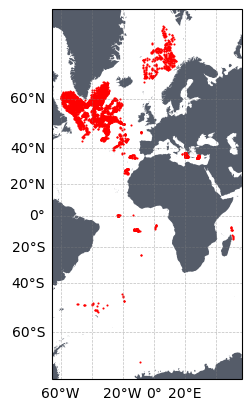

In [5]:
fig=plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.add_feature(land_feature, edgecolor=None)

ax.plot(df1['LONGITUDE'],df1['LATITUDE'],'.r', markersize=3, markeredgecolor='None', alpha=1, transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

In [6]:
import scipy.stats as stats
x=df1['GROUNDING_DEPTH'].values
y=((df1['etopo_min']+df1['etopo_max'])/2).values
yb=((df1['gebco_min']+df1['gebco_max'])/2).values
res = stats.linregress(x, yb)

Text(0, 0.5, '~Bathy [m]')

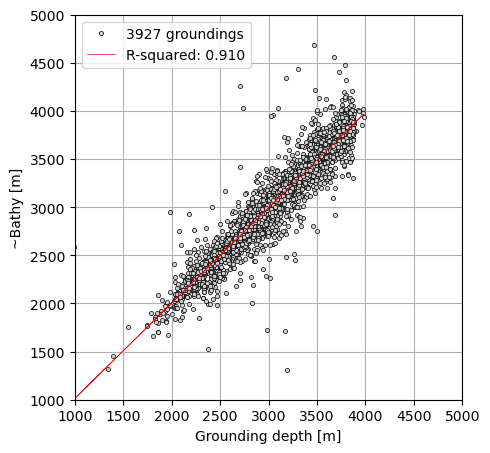

In [11]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(x,y,'o',label=f"{len(x)} groundings", color='lightgrey', markersize=3, markeredgecolor='k', markeredgewidth=0.5)
#a=ax.scatter(x,y,s=4,c=df1['N_PROF'])
#plt.colorbar(a)
plt.plot(x, res.intercept + res.slope*x, 'r',linewidth=0.5,label=f"R-squared: {res.rvalue**2:.3f}")
ax.set_xlim([1000,5000])
ax.set_ylim([1000,5000])
ax.legend()
ax.set_xlabel('Grounding depth [m]')
ax.set_ylabel('~Bathy [m]')
#fig.savefig('groundingVsBathy.png')

## USE CASE 1

In [15]:
dfu1 = df1.where((((df1['etopo_min']+df1['etopo_max'])/2)<1500) & (df1['GROUNDING_DEPTH']>3000),drop=True)

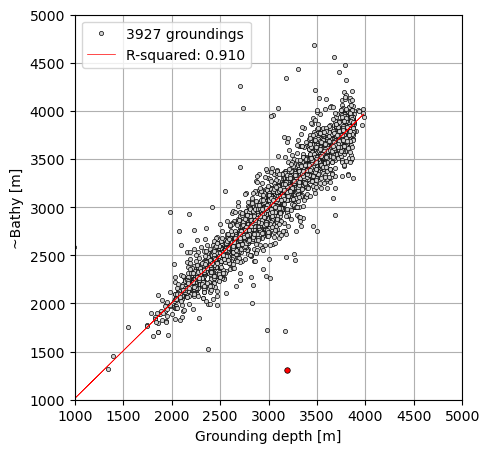

In [33]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(x,y,'o',label=f"{len(x)} groundings", color='lightgrey', markersize=3, markeredgecolor='k', markeredgewidth=0.5)
ax.plot(x, res.intercept + res.slope*x, 'r',linewidth=0.5,label=f"R-squared: {res.rvalue**2:.3f}")
ax.set_xlim([1000,5000])
ax.set_ylim([1000,5000])
ax.legend()
ax.set_xlabel('Grounding depth [m]')
ax.set_ylabel('~Bathy [m]')

ax.plot(dfu1['GROUNDING_DEPTH'],((dfu1['etopo_min']+dfu1['etopo_max'])/2),'o',color='red', markersize=4, markeredgecolor='k', markeredgewidth=0.5)

In [41]:
print(dfu1.WMO.values,dfu1.GROUNDING_DATE.values,dfu1.GROUNDING_DEPTH.values)

[6903082.] ['2021-12-15T09:03:00.000000000'] [3187.02076049]


In [36]:
#GET DESCENT RATE FOR THAT GROUNDING ?
dt = xr.open_dataset('/home/ref-argo/gdac/dac/coriolis/6903082/6903082_Rtraj.nc')

In [37]:
grds = dt[['CYCLE_NUMBER','JULD','PRES','LATITUDE','LONGITUDE']].where(dt['MEASUREMENT_CODE']==901.,drop=True).groupby('CYCLE_NUMBER').last()
grds

<xarray.Dataset>
Dimensions:       (CYCLE_NUMBER: 90)
Coordinates:
  * CYCLE_NUMBER  (CYCLE_NUMBER) float64 1.0 2.0 3.0 4.0 ... 87.0 88.0 89.0 90.0
Data variables:
    JULD          (CYCLE_NUMBER) datetime64[ns] 2021-06-18T10:07:00 ... 2023-...
    PRES          (CYCLE_NUMBER) float32 3.258e+03 3.15e+03 ... 2.903e+03
    LATITUDE      (CYCLE_NUMBER) float64 nan nan nan nan nan ... nan nan nan nan
    LONGITUDE     (CYCLE_NUMBER) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    title:                        Argo float trajectory file
    institution:                  CORIOLIS
    source:                       Argo float
    history:                      2021-09-28T10:01:07Z creation; 2023-11-25T1...
    references:                   http://www.argodatamgt.org/Documentation
    user_manual_version:          3.4
    Conventions:                  Argo-3.2 CF-1.6
    featureType:                  trajectory
    decoder_version:              CODA_058i
    id:                           https://doi.org/10.17882/42182
    comment_on_resolution:        JULD and PRES variable resolutions depend o...
    comment_on_measurement_code:  Meaning of some specific measurement codes ...

In [50]:
grds['CYCLE_NUMBER'].isel(CYCLE_NUMBER=np.argmin(np.abs(grds['JULD'].values-dfu1['GROUNDING_DATE'].values)))

<xarray.DataArray 'CYCLE_NUMBER' ()>
array(19.)
Coordinates:
    CYCLE_NUMBER  float64 19.0
Attributes:
    long_name:    Float cycle number of the measurement
    conventions:  0...N, 0 : launch cycle, 1 : first complete cycle

In [47]:
descent = dt[['CYCLE_NUMBER','JULD','PRES','LATITUDE','LONGITUDE']].where((dt['MEASUREMENT_CODE']==389.)&(dt['CYCLE_NUMBER']==19),drop=True)
descent

<xarray.Dataset>
Dimensions:       (N_MEASUREMENT: 6)
Dimensions without coordinates: N_MEASUREMENT
Data variables:
    CYCLE_NUMBER  (N_MEASUREMENT) float64 19.0 19.0 19.0 19.0 19.0 19.0
    JULD          (N_MEASUREMENT) datetime64[ns] 2021-12-15T05:53:00 ... 2021...
    PRES          (N_MEASUREMENT) float32 2.786e+03 2.838e+03 ... 3.241e+03
    LATITUDE      (N_MEASUREMENT) float64 nan nan nan nan nan nan
    LONGITUDE     (N_MEASUREMENT) float64 nan nan nan nan nan nan
Attributes:
    title:                        Argo float trajectory file
    institution:                  CORIOLIS
    source:                       Argo float
    history:                      2021-09-28T10:01:07Z creation; 2023-11-25T1...
    references:                   http://www.argodatamgt.org/Documentation
    user_manual_version:          3.4
    Conventions:                  Argo-3.2 CF-1.6
    featureType:                  trajectory
    decoder_version:              CODA_058i
    id:                           https://doi.org/10.17882/42182
    comment_on_resolution:        JULD and PRES variable resolutions depend o...
    comment_on_measurement_code:  Meaning of some specific measurement codes ...

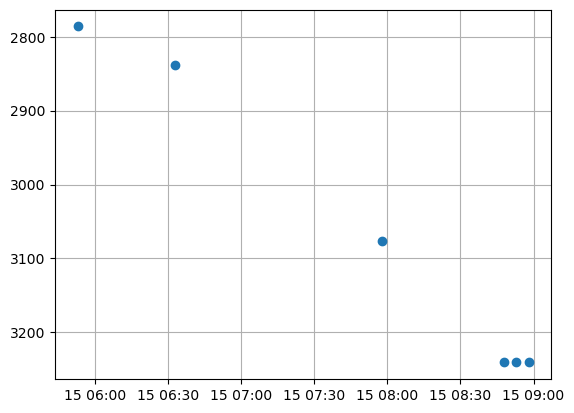

In [52]:
plt.plot(descent['JULD'],descent['PRES'],'o')
plt.gca().invert_yaxis()